#### Question 9.1
>Using the same crime data set uscrime.txt as in Question 8.2, apply Principal Component Analysis and then create a regression model using the first few principal components. Specify your new model in terms of the original variables (not the principal components), and compare its quality to that of your solution to Question 8.2. You can use the R function prcomp for PCA. (Note that to first scale the data, you can include scale. = TRUE to scale as part of the PCA function. Don’t forget that, to make a prediction for the new city, you’ll need to unscale the coefficients (i.e., do the scaling calculation in reverse)!)

To apply a Principal Component Analysis (PCA) to the crime data I am going to use the prcomp() function, information about the function can be found at https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/prcomp. After completing the PCA I'll use the lm() function that is a part of the stats package which is one of R's base packages to create the linear regression model.

I found the found the explanation of PCA in R from datacamp very userful and adopted several of the techniques they described, it can be found here: https://www.datacamp.com/tutorial/pca-analysis-r. PCA is a statistical technique used for dimensionality reduction and feature extraction. It aims to transform a dataset of possibly correlated variables into a set of linearly uncorrelated variables called principal components. These components are ordered by the amount of variance they explain in the data, with the first principal component explaining the most variance, the second component explaining the second most, and so on. PCA achieves this transformation by finding the eigenvectors (principal components) of the covariance matrix of the dataset. We know from the previous homework that we have several variables with multicollinearity which PCA should help address. 

In order to use PCA on the crimes dataset and then apply the lm() function to create a linear regression model I am going to follow the steps below:

1) Explore the data to gain a better understanding of the dataset
2) Normalize the data
3) Look at correlation values
4) Apply the PCA
5) Determine optimal number of principal components
6) Create new linear regression model in terms of the original variables
7) Compare the new model to the solution from the previous homework

#### Step 1 - Explore the Data
For this step I am going to visually inspect the data, get summary statistics to get a sense of the properties of the values in the data, and read about the data to understand what each value represents.  I'll start by loading the libraries I need for this analysis and loading the data.

In [23]:
# Set seed so output is reproducible
set.seed(123)

# Load libraries needed for analysis
library(ggplot2)
library(dplyr)
library(pastecs)
library(corrr)
library(ggcorrplot)
library(factoextra)
library(FactoMineR)
library(DAAG)

In [2]:
# Load the data
crime_data <- read.table("uscrime.txt", header = TRUE)

In [3]:
# Visually inspect the data, for this report I only printed the first few rows but inspected all of them
head(crime_data[,1:10])
head(crime_data[,11:16])

M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1
15.1,1,9.1,5.8,5.6,0.510,95.0,33,30.1,0.108
14.3,0,11.3,10.3,9.5,0.583,101.2,13,10.2,0.096
14.2,1,8.9,4.5,4.4,0.533,96.9,18,21.9,0.094
13.6,0,12.1,14.9,14.1,0.577,99.4,157,8.0,0.102
14.1,0,12.1,10.9,10.1,0.591,98.5,18,3.0,0.091
12.1,0,11.0,11.8,11.5,0.547,96.4,25,4.4,0.084


U2,Wealth,Ineq,Prob,Time,Crime
4.1,3940,26.1,0.084602,26.2011,791
3.6,5570,19.4,0.029599,25.2999,1635
3.3,3180,25.0,0.083401,24.3006,578
3.9,6730,16.7,0.015801,29.9012,1969
2.0,5780,17.4,0.041399,21.2998,1234
2.9,6890,12.6,0.034201,20.9995,682


In [4]:
# Look at a summary of the data
summary(crime_data)

       M               So               Ed             Po1       
 Min.   :11.90   Min.   :0.0000   Min.   : 8.70   Min.   : 4.50  
 1st Qu.:13.00   1st Qu.:0.0000   1st Qu.: 9.75   1st Qu.: 6.25  
 Median :13.60   Median :0.0000   Median :10.80   Median : 7.80  
 Mean   :13.86   Mean   :0.3404   Mean   :10.56   Mean   : 8.50  
 3rd Qu.:14.60   3rd Qu.:1.0000   3rd Qu.:11.45   3rd Qu.:10.45  
 Max.   :17.70   Max.   :1.0000   Max.   :12.20   Max.   :16.60  
      Po2               LF              M.F              Pop        
 Min.   : 4.100   Min.   :0.4800   Min.   : 93.40   Min.   :  3.00  
 1st Qu.: 5.850   1st Qu.:0.5305   1st Qu.: 96.45   1st Qu.: 10.00  
 Median : 7.300   Median :0.5600   Median : 97.70   Median : 25.00  
 Mean   : 8.023   Mean   :0.5612   Mean   : 98.30   Mean   : 36.62  
 3rd Qu.: 9.700   3rd Qu.:0.5930   3rd Qu.: 99.20   3rd Qu.: 41.50  
 Max.   :15.700   Max.   :0.6410   Max.   :107.10   Max.   :168.00  
       NW              U1                U2            

I don't like the labels for some of the columns in the data as it is hard to understand what they represent just by their name. A description of the attributes taken from the website can be seen below. Next, I am going to rename my columns to match the descriptions a little better. I am also going to make a couple of tweaks to the data, I am going to turn the LF, M.F, U1, and Prob variables into percentages to match the M, NW, U2 and Ineq variables. It seems odd that the U2 variable would be as a percentage and the U1 variable is set as a ratio since they represent the same thing for different age groups. I also just want the consistency of having everything listed as a percentage. I will of course have to apply the same transformation to the values from the data point we are trying to predict.

    M:      percentage of males aged 14-24 in total state population
    So:     indicator variable for Southern states (0 = No, 1 = Yes)
    Ed:     mean years of schooling of the population aged 25 years or over
    Po1:    per capita expenditure on police protection in 1960
    Po2:    per capita expenditure on police protection in 1959
    LF:     labor force participation rate of civilian urban males in the age-group 14-24
    M.F:    number of males per 100 females
    Pop:    state population size in hundred thousands
    NW:     percentage of nonwhites in the population
    U1:     unemployment rate of urban males 14-24
    U2:     unemployment rate of urban males 35-39
    Wealth: median value of transferable assets or family income
    Ineq:   percentage of families earning below half the median income
    Prob:   probability of imprisonment: ratio of number of commitments to number of offenses
    Time:   average time in months served by offenders in state prisons before their first release
    Crime:  number of offenses per 100,000 population in 1960

In [5]:
# Assign more meaningful variable names and update several values in the dataset (not necessary but it makes it easier for me to interpret)
# %>% is a pipe operator that allows several operations (rename and mutate) to occur
crime_data <- crime_data %>%
  rename(percent_young_male = M,
         southern_state = So,
         average_ed = Ed,
         per_cap_exp_1960 = Po1,
         per_cap_exp_1959 = Po2,
         laborforce_part = LF,
         percent_male = M.F,
         population = Pop,
         nonwhite = NW,
         unemp_youth = U1,
         unemp_adult = U2,
         median_assets = Wealth,
         low_income = Ineq,
         prob_imprisonment = Prob,
         time_served = Time,
         crimes_per_million = Crime) %>%
  mutate(laborforce_part = laborforce_part * 100,
         percent_male = (percent_male / (percent_male + 100)) * 100,
         unemp_youth = unemp_youth * 100,
         prob_imprisonment = prob_imprisonment * 100)

# print summary of the transformed data
summary(crime_data)

 percent_young_male southern_state     average_ed    per_cap_exp_1960
 Min.   :11.90      Min.   :0.0000   Min.   : 8.70   Min.   : 4.50   
 1st Qu.:13.00      1st Qu.:0.0000   1st Qu.: 9.75   1st Qu.: 6.25   
 Median :13.60      Median :0.0000   Median :10.80   Median : 7.80   
 Mean   :13.86      Mean   :0.3404   Mean   :10.56   Mean   : 8.50   
 3rd Qu.:14.60      3rd Qu.:1.0000   3rd Qu.:11.45   3rd Qu.:10.45   
 Max.   :17.70      Max.   :1.0000   Max.   :12.20   Max.   :16.60   
 per_cap_exp_1959 laborforce_part  percent_male     population    
 Min.   : 4.100   Min.   :48.00   Min.   :48.29   Min.   :  3.00  
 1st Qu.: 5.850   1st Qu.:53.05   1st Qu.:49.10   1st Qu.: 10.00  
 Median : 7.300   Median :56.00   Median :49.42   Median : 25.00  
 Mean   : 8.023   Mean   :56.12   Mean   :49.56   Mean   : 36.62  
 3rd Qu.: 9.700   3rd Qu.:59.30   3rd Qu.:49.80   3rd Qu.: 41.50  
 Max.   :15.700   Max.   :64.10   Max.   :51.71   Max.   :168.00  
    nonwhite      unemp_youth      unemp_

In [6]:
# Double check size of the data
cat('Rows','Columns')
t(dim(crime_data))

Rows Columns

47,16


Everyone should be pretty familar with the data at this point so I won't go much into explaining it.

#### Step 2 - Normalize the Data
When performing PCA analysis it is important to normalize the data so the results aren't biased. Normalization ensures that each attribute has the same level of contribution, preventing one variable from dominating others. For each variable, normalization is done by subtracting its mean and dividing by its standard deviation.

In [7]:
normalized_data <- scale(crime_data)

stat.desc(normalized_data[,1:4])
stat.desc(normalized_data[,5:8])
stat.desc(normalized_data[,9:12])
stat.desc(normalized_data[,13:16])

,percent_young_male,southern_state,average_ed,per_cap_exp_1960
nbr.val,4.700000e+01,4.700000e+01,4.700000e+01,4.700000e+01
nbr.null,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
nbr.na,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
min,-1.557530e+00,-7.107373e-01,-1.666068e+00,-1.345942e+00
max,3.057499e+00,1.377054e+00,1.462564e+00,2.725532e+00
range,4.615029e+00,2.087791e+00,3.128632e+00,4.071473e+00
sum,2.727679e-14,-7.771561e-16,-3.361894e-14,-5.412337e-16
median,-2.048491e-01,-7.107373e-01,2.111113e-01,-2.355398e-01
mean,5.803827e-16,-1.653754e-17,-7.153082e-16,-1.153695e-17
SE.mean,1.458650e-01,1.458650e-01,1.458650e-01,1.458650e-01


,per_cap_exp_1959,laborforce_part,percent_male,population
nbr.val,4.700000e+01,4.700000e+01,4.700000e+01,4.700000e+01
nbr.null,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
nbr.na,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
min,-1.403154e+00,-2.009103e+00,-1.715591e+00,-8.830043e-01
max,2.745434e+00,1.974881e+00,2.914211e+00,3.450982e+00
range,4.148588e+00,3.983983e+00,4.629802e+00,4.333986e+00
sum,1.114733e-14,1.790235e-15,4.798592e-14,1.377370e-15
median,-2.587161e-01,-2.948369e-02,-1.933488e-01,-3.051394e-01
mean,2.371462e-16,3.807856e-17,1.021009e-15,2.932190e-17
SE.mean,1.458650e-01,1.458650e-01,1.458650e-01,1.458650e-01


,nonwhite,unemp_youth,unemp_adult,median_assets
nbr.val,4.700000e+01,4.700000e+01,4.700000e+01,4.700000e+01
nbr.null,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
nbr.na,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
min,-9.640066e-01,-1.412635e+00,-1.655178e+00,-2.460158e+00
max,3.130176e+00,2.580979e+00,2.844286e+00,1.695672e+00
range,4.094183e+00,3.993614e+00,4.499464e+00,4.155830e+00
sum,3.722717e-15,-1.146305e-14,6.246739e-15,-5.929285e-15
median,-2.443640e-01,-1.923638e-01,2.519297e-03,1.203949e-01
mean,7.924134e-17,-2.438740e-16,1.328955e-16,-1.261250e-16
SE.mean,1.458650e-01,1.458650e-01,1.458650e-01,1.458650e-01


,low_income,prob_imprisonment,time_served,crimes_per_million
nbr.val,4.700000e+01,4.700000e+01,4.700000e+01,4.700000e+01
nbr.null,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
nbr.na,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
min,-1.704429e+00,-1.767666e+00,-2.031683e+00,-1.455893e+00
max,2.055341e+00,3.197990e+00,2.455586e+00,2.812874e+00
range,3.759770e+00,4.965657e+00,4.487268e+00,4.268767e+00
sum,1.763520e-14,1.291718e-15,-1.110223e-16,-6.418477e-15
median,-4.511724e-01,-2.195272e-01,-1.125064e-01,-1.915518e-01
mean,3.751916e-16,2.748683e-17,-2.343722e-18,-1.365181e-16
SE.mean,1.458650e-01,1.458650e-01,1.458650e-01,1.458650e-01


As you can see from the summary above, all of our data now has a mean of effectively 0 with a standard deviation of 1. The data has been centered and scaled!

#### Step 3 - Look at Correlation Values
One of the main benefits of a PCA is that it helps prevent colinearity. Next, I am going to print the correlation matrix to see what variables with high colinearity values might exist.

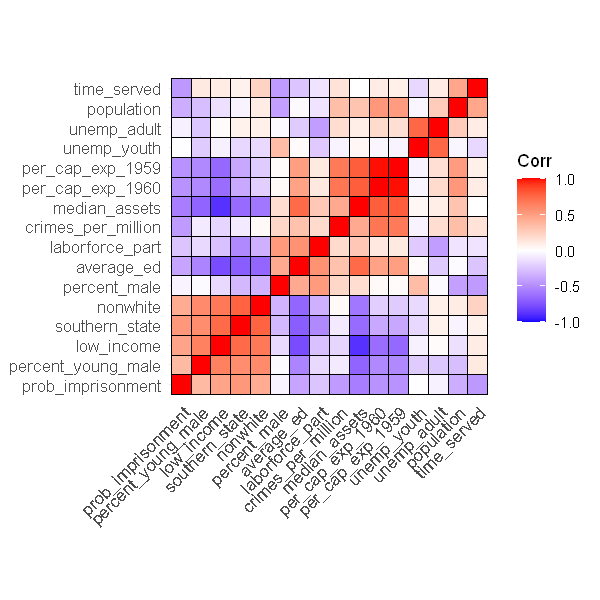

In [8]:
# Calculate the corelatinp coefficients between all variables
correlations <- cor(normalized_data)

# Plot heatmap
options(repr.plot.width=5, repr.plot.height=5)
ggcorrplot(correlations, hc.order = TRUE, outline.color = "Black", tl.cex = 10)

Looking at the heatmap a couple things jump out, the first is the high correlation coefficient which implies colinearity between unemp_adult and unemp_yout, per_cap_exp_1959 and per_cap_exp_1960, median_assets and low_income, and between average_ed and low_income. I've included a correlation plot matrix of some of the variables below, I didn't include all of them because the plot was too big. I thought it was another interesting way to look at correlation values. Next I'll perform the PCA.

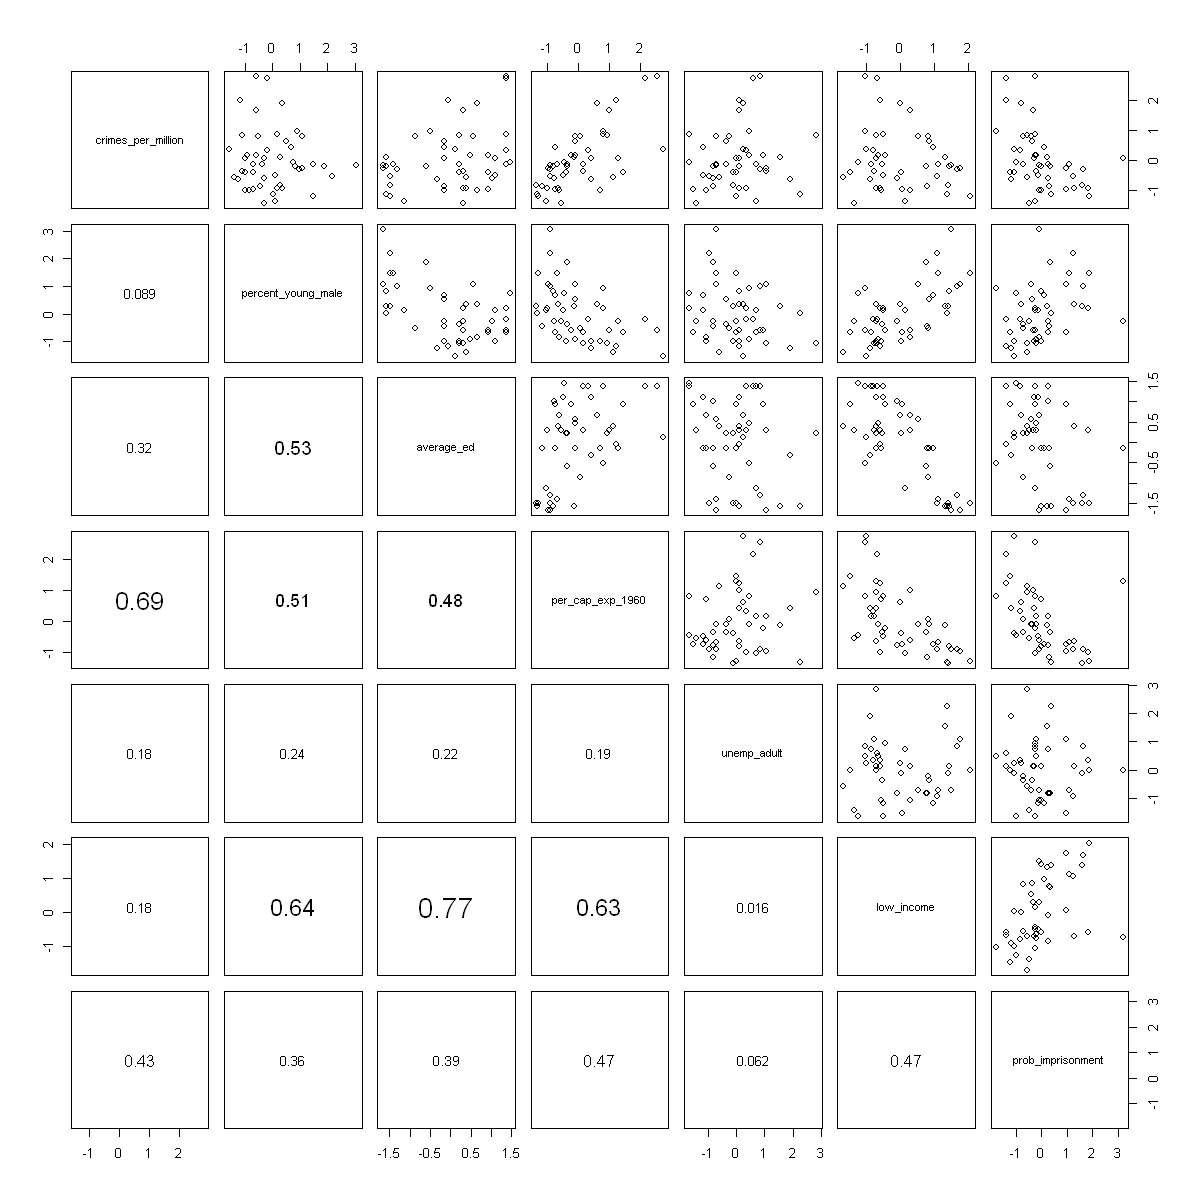

In [9]:
# Function taken from pairs Example section.  
panel.cor <- function(x, y, digits = 2, prefix = "", cex.cor, ...)
{
    usr <- par("usr"); on.exit(par(usr))
    par(usr = c(0, 1, 0, 1))
    r <- abs(cor(x, y))
    txt <- format(c(r, 0.123456789), digits = digits)[1]
    txt <- paste0(prefix, txt)
    if(missing(cex.cor)) cex.cor <- 0.8/strwidth(txt)
    text(0.5, 0.5, txt, cex = pmax(1, cex.cor * r))
}

# Set size of plot area
options(repr.plot.width=10, repr.plot.height=10)

# Use panel.cor to display correlations in lower panel.
variables <- c('crimes_per_million', 'percent_young_male', 'average_ed', 'per_cap_exp_1960', 'unemp_adult', 'low_income', 'prob_imprisonment')
pairs(normalized_data[,variables], lower.panel = panel.cor)

#### Step 4 - Apply the Principal Component Analyis

In [10]:
crimes_pca <- prcomp(normalized_data[,1:15])
summary(crimes_pca)

Importance of components:
                          PC1    PC2    PC3     PC4    PC5     PC6     PC7
Standard deviation     2.4530 1.6758 1.4152 1.07804 0.9775 0.74370 0.56714
Proportion of Variance 0.4011 0.1872 0.1335 0.07748 0.0637 0.03687 0.02144
Cumulative Proportion  0.4011 0.5884 0.7219 0.79935 0.8630 0.89992 0.92137
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.55460 0.48660 0.44679 0.41824 0.35817 0.26333 0.24157
Proportion of Variance 0.02051 0.01579 0.01331 0.01166 0.00855 0.00462 0.00389
Cumulative Proportion  0.94187 0.95766 0.97097 0.98263 0.99118 0.99580 0.99969
                          PC15
Standard deviation     0.06792
Proportion of Variance 0.00031
Cumulative Proportion  1.00000

From the previous screenshot, we notice that 15 principal components have been generated (Comp.1 to Comp.15), which also correspond to the number of variables in the data.

Each component explains a percentage of the total variance in the data set. In the cumulative proportion section, the first principal component explain\~40% of the total variance. The second one explain\~19% of the total vartionan making the cumalitve proportion \~59%. By the sixth component the cumulative proprtion is ~90% and each subsequent component accounts for less than 3% of the total variance. You can also see that the amount of variance each principal component explains starts to diminish rapidly, explaining less than 1% by the time we get to component 12. Before deciding how many principal components to include I want to see what indpendent variables make contribute to each component and visualize them.. 

In [11]:
# Grab the influence values for the first 6 principal components
loadings_selected <- crimes_pca$rotation[, 1:6]

# Sum the absolute values for each row and add it to the loadings_selected matrix
combined_matrix <- cbind(loadings_selected, Total = rowSums(abs(loadings_selected)))

combined_matrix[, 1:4]
combined_matrix[, 5:7]

,PC1,PC2,PC3,PC4
percent_young_male,-0.30377362,0.063058521,0.1732463521,-0.022757780
southern_state,-0.33091888,-0.158155200,0.0163992283,0.291293892
average_ed,0.33968747,0.214782386,0.0669732563,0.080017143
per_cap_exp_1960,0.30865035,-0.269633106,0.0516668073,0.331423977
per_cap_exp_1959,0.31101313,-0.263813722,0.0540348333,0.350298237
laborforce_part,0.17617353,0.319599018,0.2715189261,-0.145274427
percent_male,0.11480918,0.396879297,-0.2001659575,0.005331009
population,0.11322143,-0.466190937,0.0776702738,-0.033349426
nonwhite,-0.29366045,-0.227928382,0.0803488916,0.236612943
unemp_youth,0.04031025,0.007440566,-0.6593688146,-0.182778292


,PC5,PC6,Total
percent_young_male,-0.357951171,-0.450177654,1.3709651
southern_state,-0.123753085,-0.100968976,1.0214893
average_ed,-0.026547579,-0.009325911,0.7373337
per_cap_exp_1960,-0.237596683,-0.096122881,1.2950938
per_cap_exp_1959,-0.207095012,-0.119820149,1.3060751
laborforce_part,-0.392802307,0.503419239,1.8087874
percent_male,-0.577629643,-0.074612810,1.3694279
population,-0.085290992,0.546876256,1.3225993
nonwhite,-0.362303337,0.050542576,1.2513966
unemp_youth,-0.133145345,0.016558005,1.0396013


The loading matrix shows percent_young_male, per_cap_exp_1959, laborforce_part, percent_male, population, prob_imprisonment, and time_served have the biggest influence over the first 6 principal components.

#### Step 5 - Determine the Optimal Number of Principal Components to Include
Next, I'll determine how many principal componenets to use in the analysis. I'm including several approaches but will eventually just create linear regression models for each option and use cross validation to see which option is the best. I am going to start by creating a scree plot which shows the % of variance explained by each principal component in the form of an elbow plot.s.

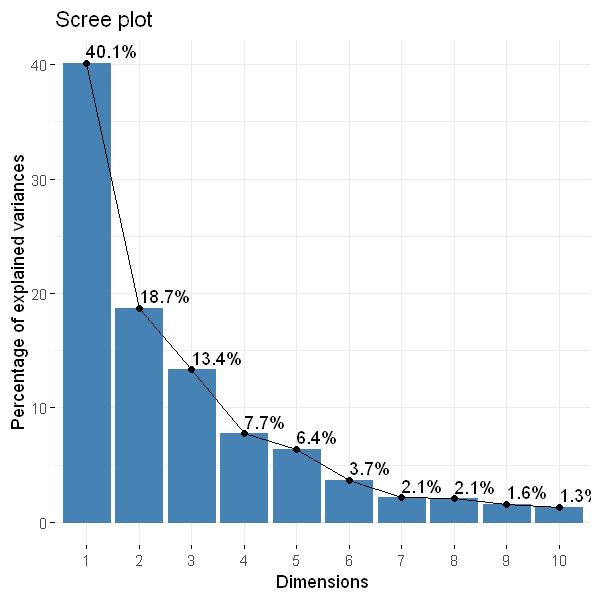

In [12]:
options(repr.plot.width=5, repr.plot.height=5)
fviz_eig(crimes_pca, addlabels = TRUE)

This plot shows a definitive change in slope from 4 to 5 and then again from 7 to 8 indicating the amount of variance explained by the variables starts to diminish at those points. Based on the scree plot and the information provided above, I think using 4 or 6 principal components could be a good option. However, since it is easy to do I am going to iterate through all of the options to see which provide me with the best linear regression model since that is our end goal. To do this I will build linear regression models using 1-15 principal components and compute the R^2 value for each model using cross validation. Since the cross validation model doesn't give me the R^2 value that I want to use to compare the models, I will compute it manually. The formula for the R^2 value is:

$$ R^2 = 1 - (RSS)/(TSS) $$

where RSS is the sum of squares of residuals and TSS is the total sum of squares. I'll calculate the R^2 values for the new models in the loop below.

In [13]:
# Create vector to store the R-squared values for each option
performance <- numeric(15)

# Calculate the TSS value
TSS <- sum((crime_data$crimes_per_million - mean(crime_data$crimes_per_million))^2)

for (i in 1:15) {
    principal_components <- crimes_pca$x[,1:i]

    # Add the crimes_per_million variable that we are trying to predict
    pc_dataset <- as.data.frame(cbind(crime_data[,16], principal_components))
    lr_model <- lm(V1~., data = pc_dataset)

    # Now that I have the model I will use cross validation to determine the r-squared value
    # Five folds is recommended for smaller datasets
    cross_val <- cv.lm(pc_dataset, lr_model, m=5, plotit = FALSE)
    RSS <- attr(cross_val, "ms") * nrow(crime_data)
    R_squared <- 1 - RSS/TSS
    performance[i] <- R_squared
}

Analysis of Variance Table

Response: V1
                     Df  Sum Sq Mean Sq F value Pr(>F)   
principal_components  1 1176998 1176998    9.29 0.0039 **
Residuals            45 5703929  126754                  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


fold 1 
Observations in test set: 9 
                         1      3       17      18      19     22      36
principal_components  -4.2  -4.17   -0.225  -0.111    2.92  -5.66    1.07
cvpred               627.9 629.77  897.810 905.534 1111.14 528.85  985.90
V1                   791.0 578.00  539.000 929.000  750.00 439.00 1272.00
CV residual          163.1 -51.77 -358.810  23.466 -361.14 -89.85  286.10
                           38      40
principal_components   -0.727   -1.06
cvpred                863.716  840.96
V1                    566.000 1151.00
CV residual          -297.716  310.04

Sum of squares = 563685    Mean square = 62632    n = 9 

fold 2 
Observations in test set: 10 
                      

In [14]:
# Get the performance values from the cross validation model
round(performance, 3)

[1] 0.071 0.123 0.097 0.039 0.507 0.522 0.533 0.473 0.435 0.413 0.282 0.381
[13] 0.351 0.418 0.421

Looking at the output from the R^2 values we see significantly higher values starting at 5 principal componenets. The model that provides the highest value uses 7 principal components but since the difference is small and part of the purpose of PCA is to reduce the number of variables I am going to **use 5 principal components for the model**. 

#### Step 6 - Create Linear Regression Model
Next, I'll create the linear regression model using the first five principal components and then convert the model back to being in terms of the original variables.

In [15]:
# Create linear regression model using first 5 principal components
principal_components <- crimes_pca$x[,1:5]

# Add the crimes_per_million variable that we are trying to predict
pc_dataset <- as.data.frame(cbind(crime_data[,16], principal_components))
lr_model <- lm(V1~., data = pc_dataset)
summary(lr_model)


Call:
lm(formula = V1 ~ ., data = pc_dataset)

Residuals:
   Min     1Q Median     3Q    Max 
-420.1 -186.3   12.6  148.1  450.7 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    905.1       35.5   25.46  < 2e-16 ***
PC1             65.2       14.6    4.45  6.4e-05 ***
PC2            -69.8       21.4   -3.26   0.0023 ** 
PC3             25.7       25.4    1.01   0.3179    
PC4             67.9       33.3    2.04   0.0480 *  
PC5           -230.4       36.8   -6.27  1.8e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 244 on 41 degrees of freedom
Multiple R-squared:  0.646,	Adjusted R-squared:  0.603 
F-statistic:   15 on 5 and 41 DF,  p-value: 2.31e-08


Next, I am going to get the coefficients from the model in terms of the principal components

In [16]:
coeff <- lr_model$coefficients
t(coeff)

(Intercept),PC1,PC2,PC3,PC4,PC5
905,65.2,-69.8,25.7,67.9,-230


Now I well get the contribution of each variable using the rotation value for the first five principal components from the PCA object. By multiplying those values by the corresponding coefficients for each principal component I can get the coefficients in terms of the original normalized variables.

In [17]:
# Look at principal component contributions for each variable
crimes_pca$rotation[,1:5]

,PC1,PC2,PC3,PC4,PC5
percent_young_male,-0.3038,0.06306,0.173246,-0.02276,-0.35795
southern_state,-0.3309,-0.15816,0.016399,0.29129,-0.12375
average_ed,0.3397,0.21478,0.066973,0.08002,-0.02655
per_cap_exp_1960,0.3087,-0.26963,0.051667,0.33142,-0.23760
per_cap_exp_1959,0.3110,-0.26381,0.054035,0.35030,-0.20710
laborforce_part,0.1762,0.31960,0.271519,-0.14527,-0.39280
percent_male,0.1148,0.39688,-0.200166,0.00533,-0.57763
population,0.1132,-0.46619,0.077670,-0.03335,-0.08529
nonwhite,-0.2937,-0.22793,0.080349,0.23661,-0.36230
unemp_youth,0.0403,0.00744,-0.659369,-0.18278,-0.13315


Next, I will multiply the contribution of each independent variable (percent_young_male, southern_state etc.) by the coeffecient for each principal component and sum those values to get the coeffecient for that variable (matrix multiplication). So for example, the new coefficient for percent_young_male will be: -0.3038(65.21) + 0.06306(-69.8) + ... = 61.15.

In [18]:
# Determine the normalized coefficients for each variable
norm_coef <- crimes_pca$rotation[,1:5] %*% coeff[2:6]
norm_coef

percent_young_male,61.15
southern_state,38.18
average_ed,20.43
per_cap_exp_1960,117.52
per_cap_exp_1959,111.59
laborforce_part,76.77
percent_male,108.08
population,59.30
nonwhite,98.36
unemp_youth,3.44
unemp_adult,32.81


The coefficients are based on the normalized data that was used for the PCA, so next I need to transform them to be used on the original data. I found the explanation given here: https://stats.stackexchange.com/questions/74622/converting-standardized-betas-back-to-original-variables useful in understanding how to reverse the transformation.

In [19]:
final_coeff <- norm_coef/sapply(crime_data[,1:15],sd)
final_coeff
final_intercept <- coeff[1] - sum(norm_coef*sapply(crime_data[,1:15],mean)/sapply(crime_data[,1:15],sd))
final_intercept

percent_young_male,48.6596
southern_state,79.7077
average_ed,18.2608
per_cap_exp_1960,39.5452
per_cap_exp_1959,39.9080
laborforce_part,18.9975
percent_male,146.2900
population,1.5577
nonwhite,9.5656
unemp_youth,1.9087
unemp_adult,38.8457


(Intercept) 
      -9602

Lastly, I want to check that the R^2 value for my new model matches the model before I transformed it. This is just a check to make sure that the transformation I applied worked correctly...

In [20]:
# Get the R-Squared value for the new transformed model
predicted_values = as.matrix(crime_data[,1:15]) %*% final_coeff + final_intercept
RSS <- sum((predicted_values - crime_data[,16])^2)
R_squared <- round(1 - RSS/TSS, digits = 3)
cat('The R^2 value for the transformed model is:', R_squared, '\n')

# Get the R^2 value from the model before transformation
summary_model <- summary(lr_model)
R_squared_original <- round(summary_model$r.squared, digits = 3)
cat('The R^2 value for the original model is:', R_squared_original, '\n')

# Check if the values match
if (R_squared_original == R_squared) {
  cat("Yay! It worked :)")
}

The R^2 value for the transformed model is: 0.646 
The R^2 value for the original model is: 0.646 
Yay! It worked :)

#### Step 7 - Compare to Previous model
I am going to start by using the new model to predict the crime value for the data point provided in the previous homework to compare it's prediction vs the previous homeworks predictions. I will also compare the R^2 values for the PCA model and last weeks model.

In [21]:
# Load the new data point to predict crime for:
predict_point <-data.frame(percent_young_male = 14.0, southern_state = 0, average_ed = 10.0, per_cap_exp_1960 = 12.0, 
                           per_cap_exp_1959 = 15.5, laborforce_part = 64.0, percent_male = 48.453608247, population = 150, 
                           nonwhite = 1.1, unemp_youth = 12.0, unemp_adult = 3.6, median_assets = 3200, low_income = 20.1, 
                           prob_imprisonment = 4.0, time_served = 39.0)
new_value <- final_intercept + sum(predict_point * final_coeff)

# Output the various predicted values
cat('The model that used principal components predicts the crime rate to be:', new_value, '\n')
cat('The original model from last week that used all 15 variables predicted the crime rate to be: 154', '\n')
cat('The final model from last week that only used "statistically significant" variables predicted the crime rate to be: 1304', '\n')

The model that used principal components predicts the crime rate to be: 1387 
The original model from last week that used all 15 variables predicted the crime rate to be: 154 
The final model from last week that only used "statistically significant" variables predicted the crime rate to be: 1304 


The predicted value for the PCA analysis is within the range of the crimes_per_million values of the original dataset which is good and is close to the value predicted last week using the linear regression model with reduced variables. Next, I'll compare the R-Squared values.

In [22]:
cat('The R^2 value for the PCA model is:', R_squared, '\n')
cat('The R^2 value for last weeks model using all of the variables was: 0.803', '\n')
cat('The R^2 value for the PCA model using cross-validation is:', performance[5], '\n')
cat('The R^2 value for last weeks model using all of the variables was: 0.421', '\n')

The R^2 value for the PCA model is: 0.646 
The R^2 value for last weeks model using all of the variables was: 0.803 
The R^2 value for the PCA model using cross-validation is: 0.507 
The R^2 value for last weeks model using all of the variables was: 0.421 


This shows that the model that used PCA didn't actually fit the data any better than the original model from last week. It does however show less overfitting when the cross-validation R^2 values are compared. This makes sense since it helps with colinearity which can cause overfitting. The difference is small though so I can't say that the model using PCA is any better than the model without it.